# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

ModuleNotFoundError: No module named 'google.colab'

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

## Corner and edge detection 

We'll use corner and edge detection to lower the search space in an attempt to speed thing up a bit 

In [ ]:
import cv2
import numpy as np

def medianCleaner(image):#To clean images from salt and pepper noise, but preserving sharp edges
    return cv2.medianBlur(image, 3)

def unsharp_mask(image, sigma=1.0, strength=1.5, threshold=0): #Method to sharpen edges 
    """
    Apply unsharp masking to an image
    
    Args:
        image: Input image
        sigma: Gaussian blur sigma (higher = more blur)
        strength: Enhancement strength (higher = more sharpening)
        threshold: Minimum difference threshold (optional)
    """
    # Step 1: Create blurred version
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    
    # Step 2: Calculate the mask (difference)
    mask = cv2.subtract(image, blurred)
    
    # Step 3: Optional threshold
    if threshold > 0:
        mask = np.where(np.abs(mask) < threshold, 0, mask)
    
    # Step 4: Add mask back to original
    sharpened = cv2.add(image, cv2.multiply(mask, strength))
    
    return sharpened








def detect_book_candidates(scene_path, min_area=1000, epsilon_ratio=0.02, angle_threshold=20):
    """
    Detects rectangular contours (likely books) in a shelf scene image using edge detection.

    Args:
        scene_path (str): Path to the scene image.
        min_area (int): Minimum area of contour to be considered.
        epsilon_ratio (float): Ratio for contour approximation.
        angle_threshold (float): Allowed deviation from 90-degree angles.

    Returns:
        image_with_boxes (np.ndarray): Image with drawn bounding boxes.
        boxes (list): List of 4-point boxes [(x1,y1), ..., (x4,y4)].
    """
    # Load and preprocess
    image = cv2.imread(scene_path)
    image = medianCleaner(image)
    image = unsharp_mask(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue

        # Polygonal approximation
        epsilon = epsilon_ratio * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        print(approx)
        # We're looking for 4-point shapes
        #pts = approx.reshape(4, 2)

        # Sort corners for consistency
        #pts = sort_corners(pts)

        # Angle check
        boxes.append(pts)

        # Draw box
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    return image, boxes

def sort_corners(pts):
    """Sort corners in top-left, top-right, bottom-right, bottom-left order."""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left

    return rect.astype(int)

def angle_between(v1, v2):
    """Compute angle (in degrees) between two vectors."""
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def is_rectangular(pts, tolerance):
    """Check if all angles between adjacent sides are ~90 degrees within a tolerance."""
    for i in range(4):
        v1 = pts[(i+1)%4] - pts[i]
        v2 = pts[(i+2)%4] - pts[(i+1)%4]
        angle = angle_between(v1, v2)
        if not (90 - tolerance <= angle <= 90 + tolerance):
            return False
    return True


In [26]:
import matplotlib.pyplot as plt 

scene_path = "dataset/dataset/scenes/scene_0.jpg"

image = cv2.imread(scene_path)


image_with_boxes, boxes = detect_book_candidates(scene_path)

print(f"{len(boxes)} candidate book(s) detected.")
#for i, box in enumerate(boxes):
#    print(f"Book {i}: corners={box.tolist()}")
print("ciao")
image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Detected Books')
plt.show()


[[[121 538]]

 [[118 637]]

 [[141 639]]

 [[144 542]]]


UnboundLocalError: cannot access local variable 'pts' where it is not associated with a value

(-0.5, 639.5, 639.5, -0.5)

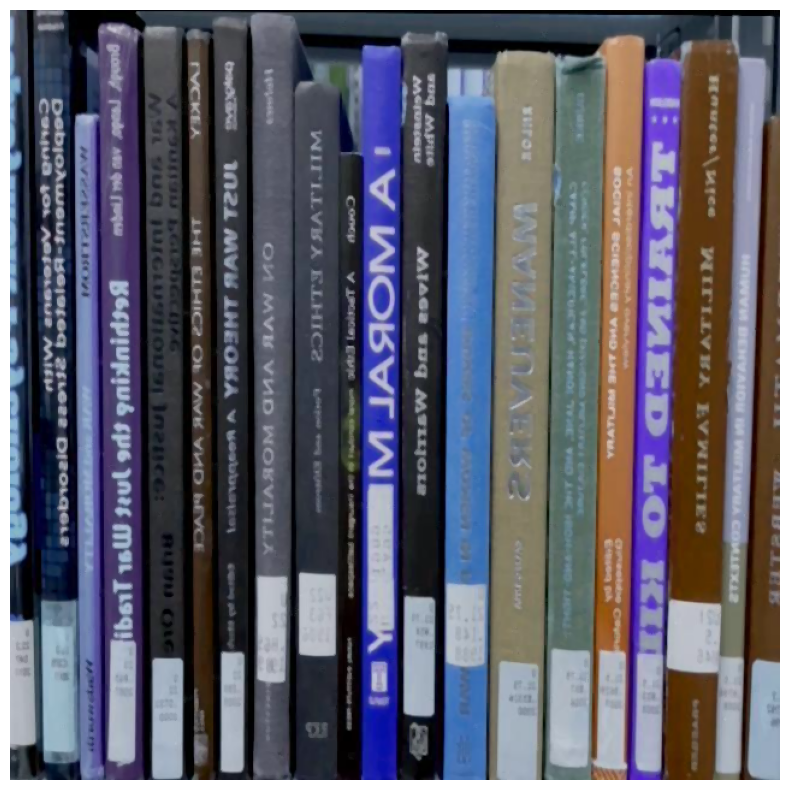

In [ ]:
cleaned = medianCleaner(image)
plt.figure(figsize=(10, 10))
plt.imshow(cleaned)
plt.axis('off')


(-0.5, 639.5, 639.5, -0.5)

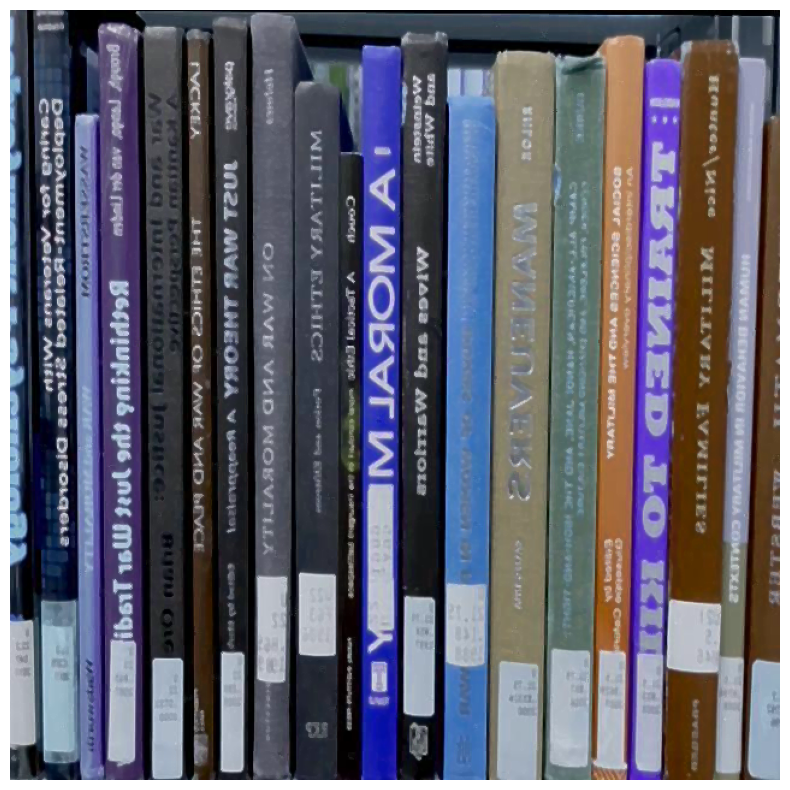

In [ ]:
sharped = unsharp_mask((cleaned))
plt.figure(figsize=(10, 10))
plt.imshow(sharped)
plt.axis('off')
